In [1]:
!pip install evaluate
!pip install rouge_score
!pip install datasets
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 9.3 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=52e22b6dfa7a01578abe165a5af7ac899fe25c54803cc5fa81dbffaa441214ac
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfull

In [2]:
import os, sys, random, re, collections, string

try:
    from datasets import load_dataset
except:
    !pip install datasets
    from datasets import load_dataset

import numpy as np
import re

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.nn import BCELoss

from tqdm.auto import tqdm

import sklearn.model_selection
import sklearn.metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import heapq

import matplotlib.pyplot as plt

import transformers
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, DataCollatorForSeq2Seq, AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

try:
    import evaluate
except:
    !pip install evaluate
    !pip install rouge_score
    import evaluate


In [3]:
# https://huggingface.co/datasets/cnn_dailymail
dataset = load_dataset('cnn_dailymail', '3.0.0')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [4]:
modelname = 'distilbert/distilgpt2'
gpt2_tokenizer = GPT2TokenizerFast.from_pretrained('distilgpt2')
gpt2_model = GPT2LMHeadModel.from_pretrained('distilbert/distilgpt2')


# tokenizer = AutoTokenizer.from_pretrained(modelname)
# model = AutoModelForSeq2SeqLM.from_pretrained(modelname)
model = gpt2_model
tokenizer = gpt2_tokenizer
tokenizer.pad_token = tokenizer.eos_token

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=modelname)
rouge = evaluate.load("rouge")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [5]:
#you can then get the individual splits
train = dataset['train'].select(range(10000))
test = dataset['test'].select(range(1000))
validation = dataset['validation']

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

train

# gpt2_tokenizer.to(device)
# gpt2_model.to(device)

Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 10000
})

In [6]:
# ctr = len(train)
# i = 0
# j = 0
# for dat in train:
#     i+=1
#     # print(i, len(dat['article'].split(' -- ')[1]))
#     # print(i, dat['article'].count('--'))
#     splitstr = re.split(r' -- ', dat['article'], 1)
#     if (re.search(r'(\([\w+]+\))|([A-Z][A-Z]+)|(\([\w\s]+\))|(\([\w]+\.[\w]+\))', splitstr[0])) is not None:
#         # print(i, splitstr)
#         j+=1
#     if i > ctr:
#         break

# print(j, j/ctr)

In [7]:
def trainModel(model):
    pass

In [8]:
def split_article(art):
    splitstr = re.split(' -- ', art, 1)
    # print(splitstr)
    if len(splitstr) == 1 or (re.search(r'(\([\w+]+\))|([A-Z][A-Z]+)|(\([\w\s]+\))|(\([\w]+\.[\w]+\))', splitstr[0])) is None:
        return art
    else:
        return splitstr[1]


def tokenize_str(examples):
    # inputs = [doc for doc in examples["article"]]
    inputs = []
    # labs = examples['highlights']

    inputs = [split_article(art) for art in examples['article']]

    # model_inputs = gpt2_tokenizer(inputs, max_length=1024, truncation=True)
    # labels = gpt2_tokenizer(text_target=labs, max_length=128, truncation=True)

    model_inputs = tokenizer(inputs, max_length=1024, truncation=True, return_tensors='pt', padding='max_length')
    # labels = tokenizer(text_target=labs, max_length=128, truncation=True)

    # model_inputs["labels"] = labels["input_ids"]
    return model_inputs


In [9]:
tokenized_train = train.map(tokenize_str, batched=True)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [10]:
tokenized_train

Dataset({
    features: ['article', 'highlights', 'id', 'input_ids', 'attention_mask'],
    num_rows: 10000
})

In [11]:
tokenized_test = test.map(tokenize_str, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [12]:
class cnnDataSet(Dataset):
    def __init__(self, data):
        self.data = data
        self.id = self.data['id']
        self.article = self.data['article']
        self.highlights = self.data['highlights']
        self.input_ids = torch.tensor(self.data['input_ids'])
        self.attention_mask = torch.tensor(self.data['attention_mask'])

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx],  self.attention_mask[idx], torch.sum(self.attention_mask[idx])



In [13]:
tokenized_train_dataset = cnnDataSet(tokenized_train)

In [14]:
[print(x, len(x), len(x[0]), len(x[1])) for i, x in enumerate(tokenized_train_dataset) if i < 5]

(tensor([18308, 14179,  3491,  ..., 50256, 50256, 50256]), tensor([1, 1, 1,  ..., 0, 0, 0]), tensor(555)) 3 1024 1024
(tensor([  464, 19646,  4314,  ..., 50256, 50256, 50256]), tensor([1, 1, 1,  ..., 0, 0, 0]), tensor(806)) 3 1024 1024
(tensor([20564,   690,   508,  ..., 50256, 50256, 50256]), tensor([1, 1, 1,  ..., 0, 0, 0]), tensor(907)) 3 1024 1024
(tensor([47087,  4615,  1936,  ..., 50256, 50256, 50256]), tensor([1, 1, 1,  ..., 0, 0, 0]), tensor(524)) 3 1024 1024
(tensor([ 464, 2351, 9957,  ...,   13,  887,  262]), tensor([1, 1, 1,  ..., 1, 1, 1]), tensor(1024)) 3 1024 1024


[None, None, None, None, None]

In [15]:
len(tokenized_train_dataset)

10000

In [16]:
# train_dataloader = DataLoader(tokenized_train_dataset, batch_size=5, shuffle=True)
# model.to(device)
from transformers import get_scheduler
from torch.optim import AdamW


In [17]:
def fine_tune_distil_gpt(train_dataset, plot_loss_curves=True, model=gpt2_model):
    '''
    Method to fine tune and train the passed model
    Returns nothing
    train_dataset - The datset whose text is in the format PASSAGE\nQUESTION?ANSWER
    '''

    # train_dataset = GPT2CustomDataset(training_text, training_labels, gpt2_tokenizer)
    # unique_labels = train_dataset.get_unique_labels()
    # unique_labels_encoding = {lab:gpt2_tokenizer.encode(lab)[0] for lab in unique_labels}
    train_dataloader = DataLoader(train_dataset, batch_size=3)

    # torch.set_default_device(device)

    # model.to(dtype=torch.float16)
    model.to(device)
    learn_rate = 1e-5
    wt_decay = 1e-5
    optimizer = AdamW(model.parameters(), lr=learn_rate, weight_decay=wt_decay)
    # lossfunc = binary_cross_entropy_with_logits().to(device)
    # print(model.parameters())
    num_epochs = 2
    dataloader_len = len(train_dataloader)
    num_training_steps = num_epochs * dataloader_len

    lr_scheduler = get_scheduler(
        name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
    )

    progress_bar = tqdm(range(num_training_steps))
    loss_list = []

    # Use FP16 for speed purposes
    scaler = torch.cuda.amp.GradScaler()
    # Update loss and other values every 3 iterations
    accum_iter = 3

    torch.cuda.empty_cache()
    model.train()
    for epoch in range(num_epochs):

        epoch_loss = []
        for  batch_idx, batch in enumerate(train_dataloader):
            with torch.set_grad_enabled(True):


                max_valid_input, max_valid_attention = trunc_batch(batch)
                if ((batch_idx + 1) % accum_iter == 0) or (batch_idx + 1 == dataloader_len):
                    optimizer.zero_grad()

                with torch.cuda.amp.autocast():

                    output = model(
                                   input_ids = max_valid_input.to(device),
                                   attention_mask=max_valid_attention.to(device),
                                   labels=max_valid_input.to(device)
                                   )
                    loss = output.loss/accum_iter

                # loss.backward()
                scaler.scale(loss).backward()
                # model.float()
                if ((batch_idx + 1) % accum_iter == 0) or (batch_idx + 1 == dataloader_len):
                    # optimizer.step()
                    scaler.step(optimizer)
                    # scaler.step(lr_scheduler)
                    # optimizer.zero_grad()
                    scaler.update()
                    lr_scheduler.step()

            progress_bar.update(1)
            if plot_loss_curves:
                loss_list.append(loss.item())
                # epoch_loss+=loss.item()
                # epoch_loss.append(loss.item())
            # break

        # loss_list.append(np.mean(epoch_loss))
        # break


    # print(betas, file=sys.stderr)
    if plot_loss_curves:
        plot_loss_curve(loss_list, f'distil-gpt2 LM LR : {learn_rate}')


def trunc_batch(batch):
    max_pad = torch.max(batch[2])
    # What we do here is that for all tensor in the batch, we truncate the attention and padding to the length of the
    # maximum valid length, so save time and memory on computing the softmaxes
    input_ids = torch.stack([b[:max_pad] for b in batch[0]])
    attention_masks = torch.stack([b[:max_pad] for b in batch[1]])

    return input_ids, attention_masks

def plot_loss_curve(losslist, rword, save_title = 'loss_curve_a2_p2.png'):
    l = len(losslist)
    plt.plot(range(l), losslist)
    plt.title(f'Plotting the loss across Iterations for "{rword}" ')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    # plt.show()
    plt.savefig(save_title)


  0%|          | 0/6668 [00:00<?, ?it/s]

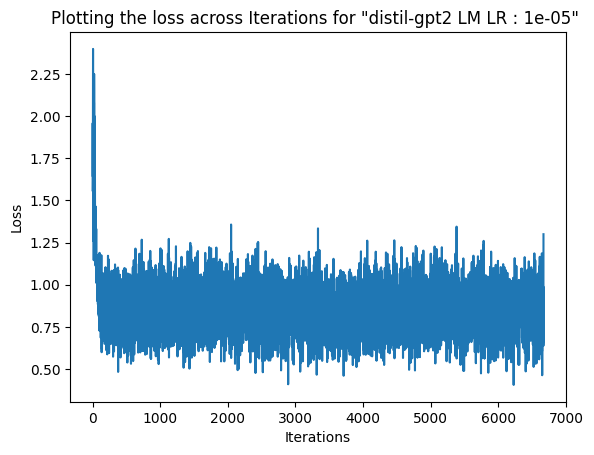

In [18]:
fine_tune_distil_gpt(tokenized_train_dataset, plot_loss_curves=True)

# ___ ___ ___ ___ __ ___ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ __ _ __ __ __ __ __ __ __ _ ____________


In [19]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = gpt2_tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

In [20]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [21]:
print(tokenized_train_dataset.shape, tokenized_test_dataset.shape)
print(tokenized_train_dataset, tokenized_test_dataset)
# print(tokenized_train_dataset['labels'])


AttributeError: 'cnnDataSet' object has no attribute 'shape'

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="cnn_trained_"+modelname,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=4,
    predict_with_generate=True,
    # fp16=True,
    )

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()